In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
!pip install rarfile

In [ ]:
import gdown
import rarfile
import os

# Correct URL after permissions are updated
url = 'https://drive.google.com/uc?id=1FAUSzwEDHfLN_McqFpQ6a3VWoc6h9qgw'
output_rar = '/content/WHEAT.rar'

# Download the RAR file
gdown.download(url, output_rar, quiet=False)

# Check if the downloaded file is valid before extracting
if os.path.exists(output_rar):
    try:
        # Try to open the downloaded file as a RAR file
        with rarfile.RarFile(output_rar, 'r') as rar_ref:
            rar_ref.extractall('/content')
        print("File extracted successfully!")
    except rarfile.NotRarFile:
        print("Error: The downloaded file is not a valid RAR archive.")
else:
    print("Error: File not found.")

Downloading...
From (original): https://drive.google.com/uc?id=1FAUSzwEDHfLN_McqFpQ6a3VWoc6h9qgw
From (redirected): https://drive.google.com/uc?id=1FAUSzwEDHfLN_McqFpQ6a3VWoc6h9qgw&confirm=t&uuid=419d3b31-d510-452a-8517-9d5ea335a91a
To: /content/WHEAT.rar
100%|██████████| 228M/228M [00:04<00:00, 49.5MB/s]


File extracted successfully!


In [ ]:
# Path to the extracted dataset folder

dataset = '/content/Wheat'

Found 4204 images belonging to 3 classes.
Found 598 images belonging to 3 classes.
Found 1198 images belonging to 3 classes.
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 76s 369ms/step - accuracy: 0.3485 - loss: 1.0957 - val_accuracy: 0.3311 - val_loss: 1.0876
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.4310 - loss: 1.0865 - val_accuracy: 0.3311 - val_loss: 1.0764
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.3727 - loss: 1.0725 - val_accuracy: 0.6472 - val_loss: 1.0607
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.5398 - loss: 1.0568 - val_accuracy: 0.6388 - val_loss: 1.0415
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.6231 - loss: 1.0380 - val_accuracy: 0.7274 - val_loss: 1.0170
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7017 - loss: 1.0130 - val_accuracy: 0.6973 - val_loss: 0.9893
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7054 - loss: 0.9904 - val_accuracy: 0.7157 - val_loss: 0.9586
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.6885 - loss: 0.9559 - val_accura

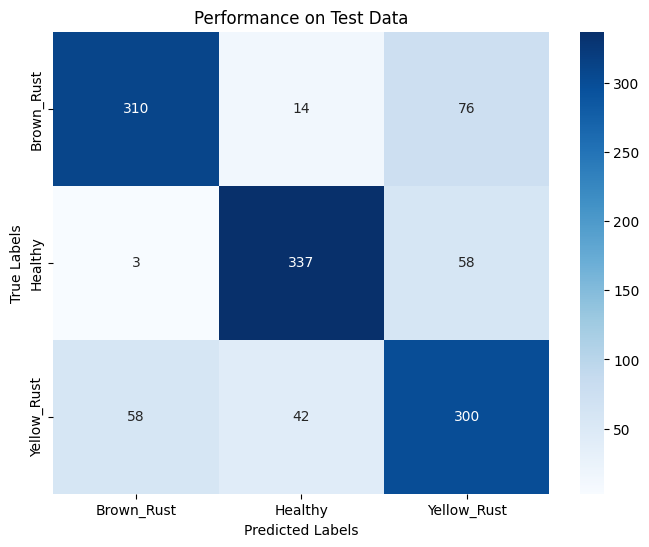

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Set the path to the dataset
data_dir = dataset  # Update this path accordingly

# Load the DenseNet121 model with pre-trained weights
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3)
)

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='swish')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # Adjust num_classes as needed

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers if you want to fine-tune only the top layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Train the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Evaluate model performance and display confusion matrix
def evaluate_model(test_generator, model, classes, title="Performance on Test Data"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)
    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)
    print(f"\n{title}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nAccuracy: {accuracy}")
    display_confusion_matrix(test_generator.labels, y_test_pred, classes, title)

# Visualize intermediate layer outputs
def display_intermediate_layers(model, image_path, layers_to_display=None):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Define the layers we want to visualize
    if layers_to_display is None:
        layers_to_display = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]

    intermediate_model = tf.keras.models.Model(inputs=model.input,
                                               outputs=[model.get_layer(layer_name).output for layer_name in layers_to_display])
    intermediate_output = intermediate_model.predict(img_array)

    for i, feature_map in enumerate(intermediate_output):
        fig, axes = plt.subplots(1, min(6, feature_map.shape[-1]), figsize=(20, 8))
        fig.suptitle(f"Layer: {layers_to_display[i]}", fontsize=16)
        for idx, ax in enumerate(axes):
            if idx >= feature_map.shape[-1]:
                break
            ax.imshow(feature_map[0, :, :, idx], cmap='viridis')
            ax.axis('off')
        plt.show()

# Evaluate and display confusion matrix
evaluate_model(test_generator, model, ['Brown_Rust', 'Healthy', 'Yellow_Rust'], title="Performance on Test Data")

# Display intermediate layer activations (Example)
# Replace 'sample_image.jpg' with an actual path to an image for testing
# display_intermediate_layers(model, 'sample_image.jpg')

